<a href="https://colab.research.google.com/github/ChiaraFor96/AML-Project/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression cost model:** implementation and comparison of machine learning models for regression
Applied Machine Learning Basic + Advanced Project


*Chiara Forresi: PhD Student in Data Science And Computation at University of Bologna*

**The problem**

The __training__ set is made up of data that I generated by running queries in the developed reaserach framework and is made up of features that indicate a block of plan operations that have been carried out:
- number of input records
- database where the operation is carried out (which determines which regression model the training data belongs to)
- database of origin
- type of macro operation (i.e. operations of preparation for joining with the other sources and subsequent operations)
- attributes that identify the number of such an operation, specifically: number of joins, unions, selections with and without index and in nested and non-nested data, aggregations, "complex" merge
- selectivity (as a product of the selections applied in the macro operation)
- aggregation (as a product of the aggregations applied in the macro operation)
- time: the execution time of the stage (this is the variable that we want to predict through a regression model)

The __goal__ is to deepen, visualize and evaluate, through the tools that python offers and that we have seen during the course, the regression model of the operations done in Spark (which is the one on which most of the computation is based) and create and compare regression models that deal with both parts of the basic part of the course and advanced parts.

The __tools__ that I will in this project are _sklearn_, _keras_ and other useful tools for python like _matplotlib_, _pandas_ and _numpy_.


# Data analysis and preprocessing


In [ ]:
# import packages and modules for data analysis and preparation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import csv
from matplotlib.gridspec import GridSpec
import matplotlib
from matplotlib import rc
import seaborn as sns
%matplotlib inline


## Utils


In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages
# def savePdf(name) :   
#   pp = PdfPages(name + '.pdf')
#   pp.savefig( fig, dpi=300, bbox_inches = "tight" )
#   pp.close()
def plot_prediction(test_labels, test_predictions):
  error = test_labels - test_predictions
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  lim = max(max(test_labels), max(test_predictions))
  plt.show()
  # # sns.distplot(error)

In [ ]:
#load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/ChiaraFor96/AML-Project/main/all_reduced.csv', quotechar='"', sep=",", quoting=csv.QUOTE_ALL, header=None)
#rename dataset column
data.columns = ['queryName', 'dataspace', 'db', 'alignmentOrJoin', 'alignmentJoinType', 'numberOfRecords', 'numberOfJoins', 'numberOfUnions', 'numberOfSelections',
      'numberOfAggregations', 'numberOfComplexMerge', 'selectivity', 'aggregations', 'numberOfUnnests',
      'numberOfSelectionsOuterWithIndex', 'numberOfSelectionsOuterWithoutIndex', 'numberOfSelectionsInnerWithIndex', 'numberOfSelectionsInnerWithoutIndex', 'localDb', 'configurationType',
      'time']

db =  'Spark' #'Relational', 'Documental'

#filter the dataset data
data = data[data.db == db]

#one hot encoding of the used categorical columns
if db == 'Spark':
  for f in ['alignmentOrJoin']:#, 'localDb'] :
    one_hot = pd.get_dummies(data[f], prefix=f)
    data = data.join(one_hot)

# bin some features data
n_bin = 5

#not bin other feature beacuse their distribution seems good
binnedFeatures = ['selectivity'] 
if db == 'Spark':
  binnedFeatures += ['aggregations', 'numberOfRecords']

for f in binnedFeatures :
  bins = np.linspace(data[f].min(),data[f].max(), n_bin) if f != 'numberOfRecords' else [0, 150000, 300000, 450000, data['numberOfRecords'].max()]
  data[f] = pd.cut(data[f], bins=bins, labels = bins[1:], include_lowest=True)
  data[f] = pd.to_numeric(data[f])

#transform the execution time in second
data['time'] = data['time']/1000

#delete not useful columns depending on the selected database (in this project use Spark)
deleteFeatures = []
if db == 'Relational' : 
  deleteFeatures = ['queryName', 'dataspace', 'db', 'alignmentOrJoin', 'localDb', 'alignmentJoinType', 'numberOfUnnests',
          'numberOfSelections', 'numberOfSelectionsOuterWithoutIndex', 'numberOfSelectionsInnerWithoutIndex', 'numberOfSelectionsInnerWithIndex', 
          'configurationType', 'numberOfComplexMerge', 'numberOfUnions', 'aggregations'] #TODO check for aggregations
elif db == 'Spark' : 
  deleteFeatures = ['queryName', 'dataspace', 'db', 'alignmentOrJoin', 'localDb', 'alignmentJoinType',
          'numberOfSelections', 'numberOfSelectionsOuterWithoutIndex', 'numberOfSelectionsInnerWithoutIndex', 
          'numberOfSelectionsInnerWithIndex', 'configurationType', 'alignmentOrJoin_A'
          ]#, 'numberOfUnnests'
elif db == 'Documental' : 
  deleteFeatures = ['queryName', 'dataspace', 'db', 'alignmentOrJoin', 'localDb', 'alignmentJoinType', 'numberOfJoins',
          'numberOfSelections', 'numberOfSelectionsOuterWithoutIndex', 'numberOfSelectionsInnerWithoutIndex', 
          'configurationType','aggregations', 'numberOfAggregations', 'numberOfComplexMerge', 'numberOfUnions'] 

for f in  deleteFeatures :
  del data[f]

data = data.reindex(sorted(data.columns), axis=1)

print(data.columns)


Index(['aggregations', 'alignmentOrJoin_J', 'numberOfAggregations',
       'numberOfComplexMerge', 'numberOfJoins', 'numberOfRecords',
       'numberOfSelectionsOuterWithIndex', 'numberOfUnions', 'numberOfUnnests',
       'selectivity', 'time'],
      dtype='object')


In [ ]:
#describe data
from pandas import set_option
set_option('display.width', 200)
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
set_option('precision', 3)    
data.describe()

,aggregations,alignmentOrJoin_J,numberOfAggregations,numberOfComplexMerge,numberOfJoins,numberOfRecords,numberOfSelectionsOuterWithIndex,numberOfUnions,numberOfUnnests,selectivity,time
count,58785.000,58785.000,58785.000,58785.00,58785.000,58785.000,58785.000,58785.000,58785.000,58785.000,58785.000
mean,0.947,0.147,0.120,0.02,0.469,186855.889,0.224,0.114,0.223,0.940,0.666
std,0.192,0.354,0.329,0.14,1.445,90486.339,2.266,0.456,0.550,0.196,1.092
min,0.250,0.000,0.000,0.00,0.000,150000.000,0.000,0.000,0.000,0.250,0.046
25%,1.000,0.000,0.000,0.00,0.000,150000.000,0.000,0.000,0.000,1.000,0.150
50%,1.000,0.000,0.000,0.00,0.000,150000.000,0.000,0.000,0.000,1.000,0.222
75%,1.000,0.000,0.000,0.00,0.000,150000.000,0.000,0.000,0.000,1.000,0.577
max,1.000,1.000,2.000,1.00,8.000,570880.000,32.000,3.000,2.000,1.000,28.066


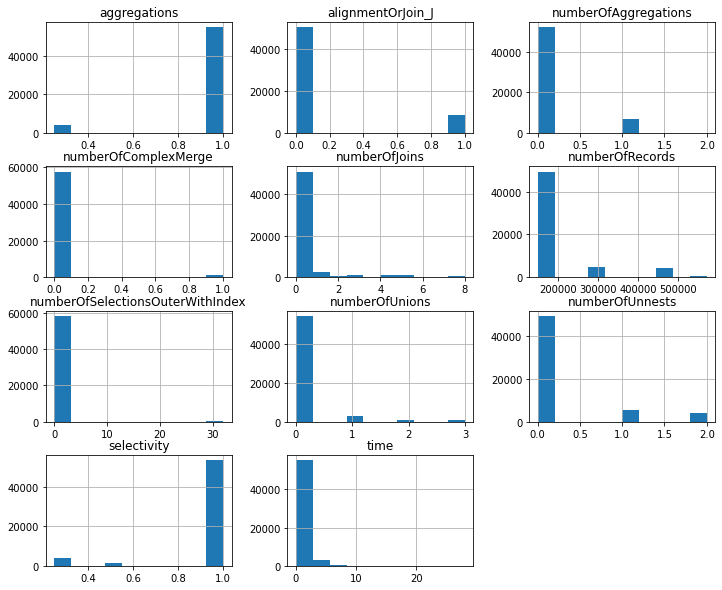

In [ ]:
data.hist(figsize = (12,10))
plt.show()


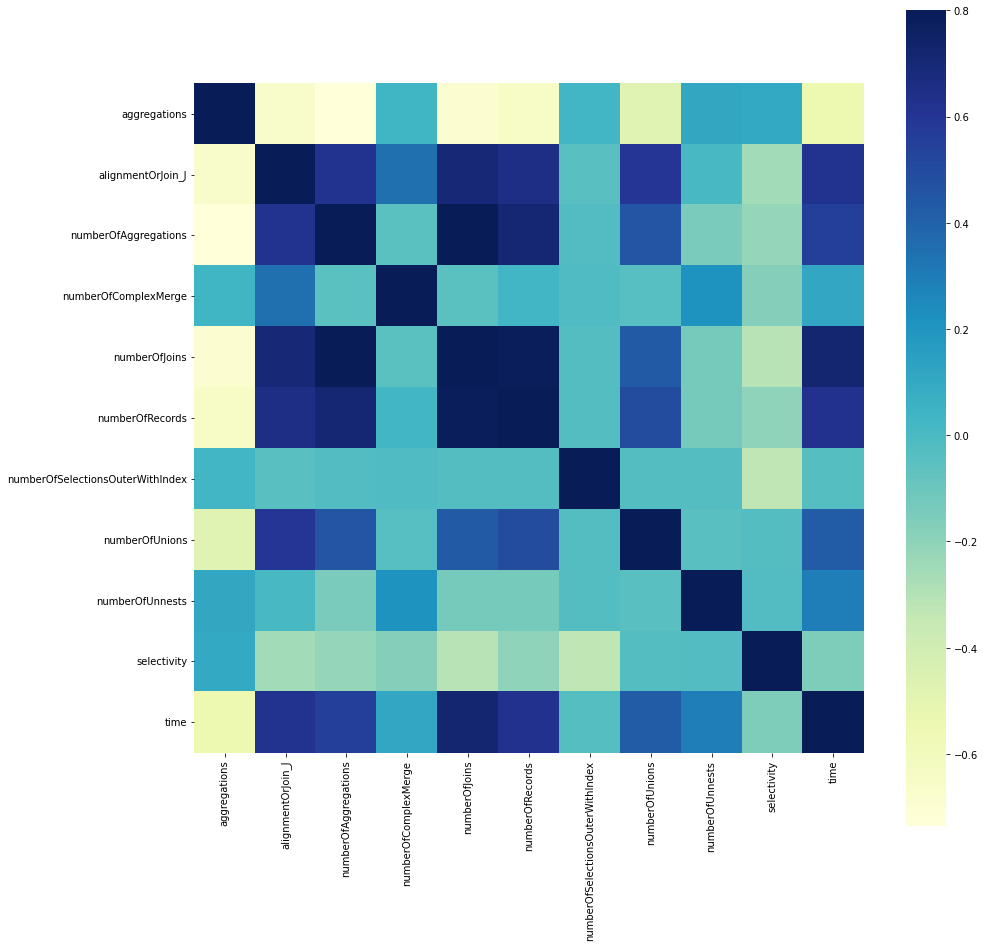

In [ ]:
#show data correlations
C_mat = data.corr()

fig = plt.figure(figsize = (15,15))
sns.heatmap(C_mat, vmax = .8, square = True, cmap="YlGnBu")
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


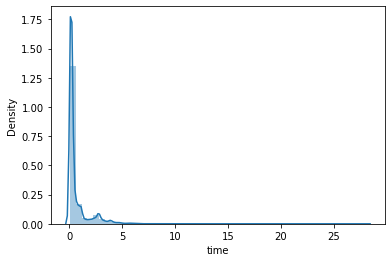

In [ ]:
#analysis of the target variable
sns.distplot(data["time"])

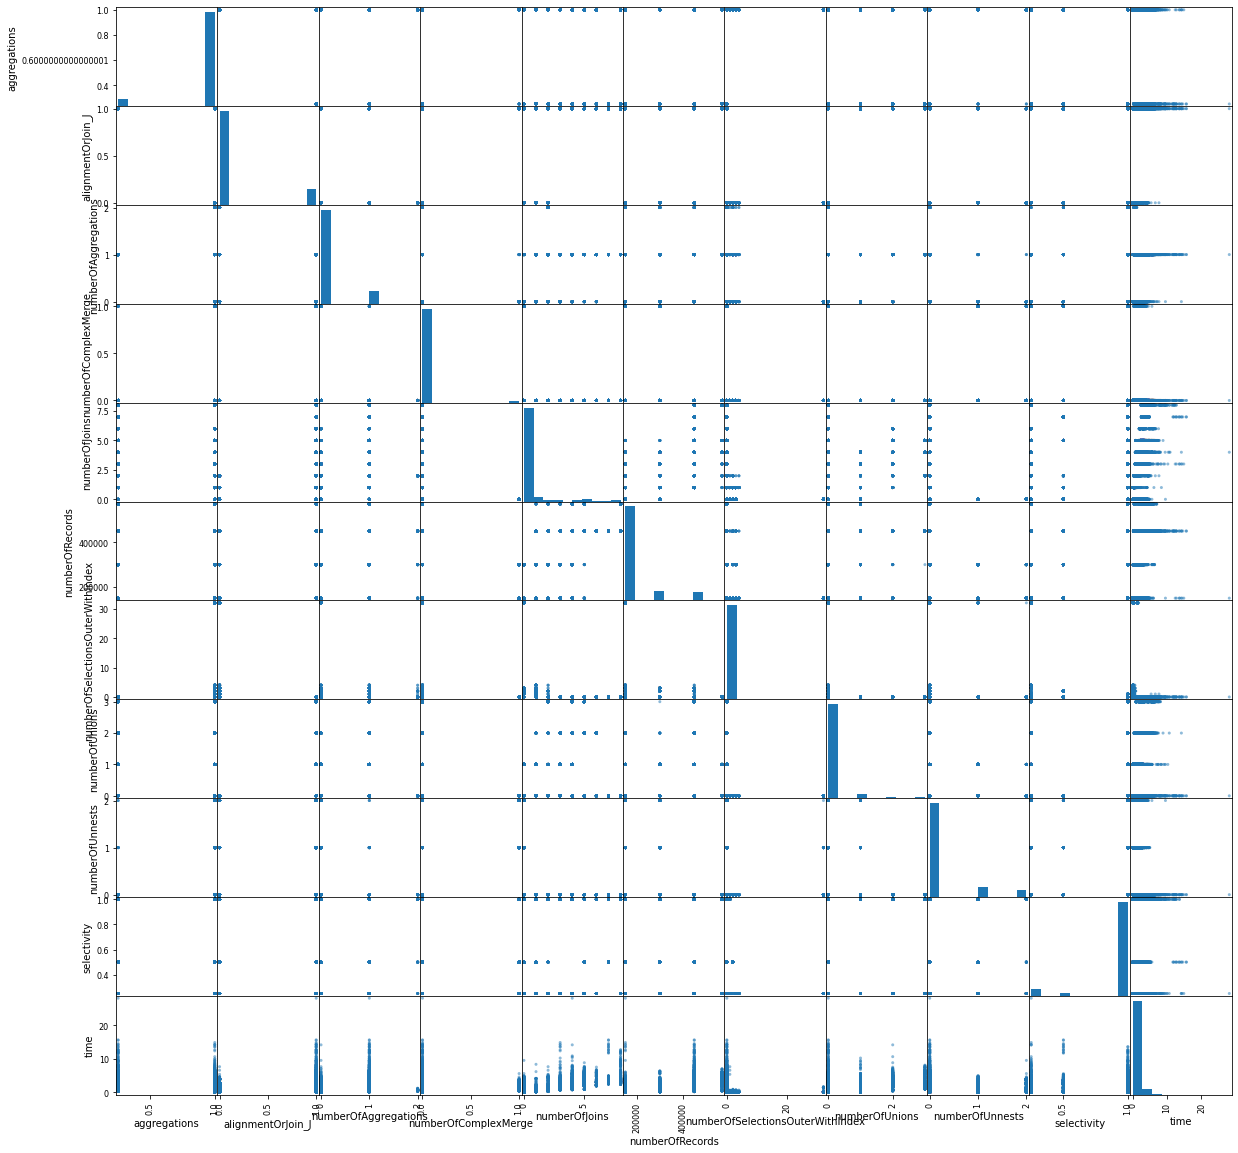

In [ ]:
#show data distribution
from pandas.plotting import scatter_matrix
scatter_matrix(data, figsize = (20, 20))
plt.show()


From the distribution of the data we see that all the selected features make a contribution in the calculation of time, but the data are not not evenly distributed in the features. The features have been selected considering the contribution of the dataset features in the collected data.
It remains clear that there is noise in the data and there are behaviors that are not quite what we expect. For example, it would be natural that as the number of records increases, the execution time would increase, but this depends on other dimensions (features) and given the amount of dimensions available, it is quite difficult to visualize the data. For this reason we try to visualize in 3D them considering the two most important features.

In [ ]:
#prepare the data for the evalaution
x_columns = [a for a in data.columns if a != 'time']
X = data[x_columns].values

print(X)
print(X.shape)

Y = data.time.values
print(Y)
print(Y.shape)

[[1.   0.   0.   ... 0.   0.   1.  ]
 [1.   0.   0.   ... 0.   0.   1.  ]
 [1.   0.   0.   ... 0.   0.   1.  ]
 ...
 [1.   0.   0.   ... 0.   0.   1.  ]
 [1.   0.   1.   ... 0.   0.   1.  ]
 [1.   1.   0.   ... 0.   1.   0.25]]
(58785, 10)
[0.254 0.176 0.213 ... 0.958 0.379 1.11 ]
(58785,)


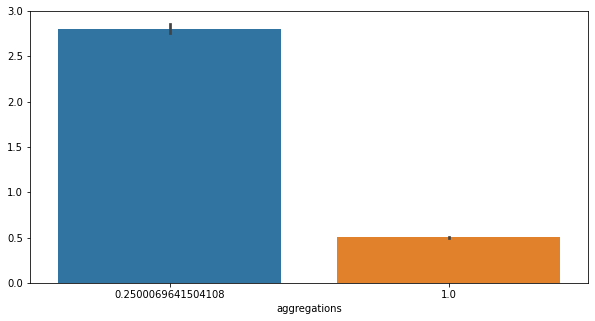

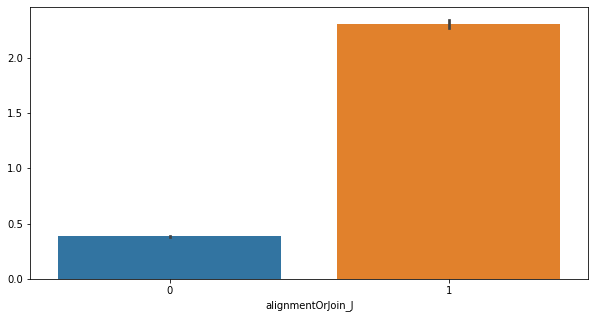

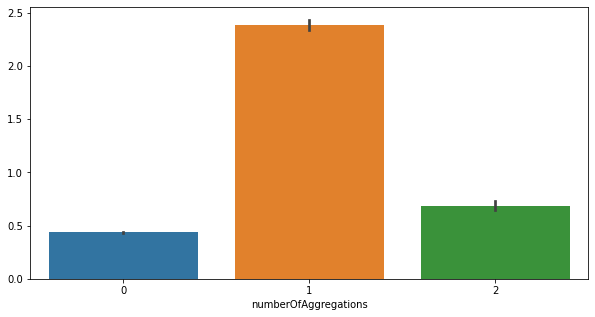

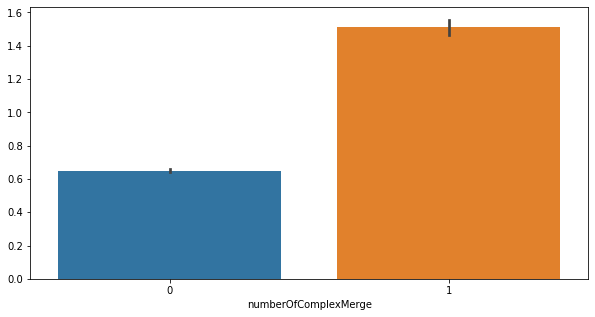

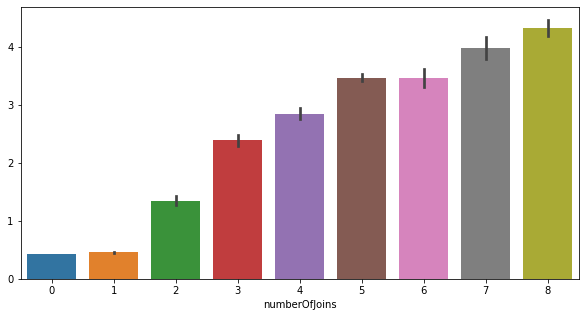

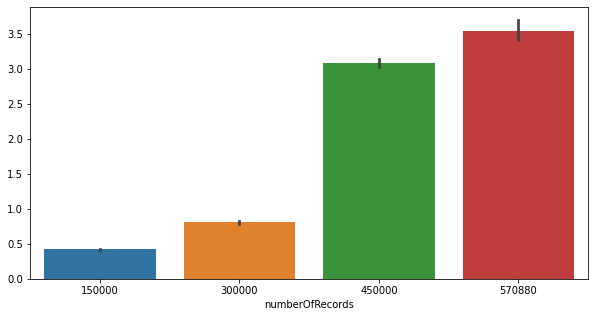

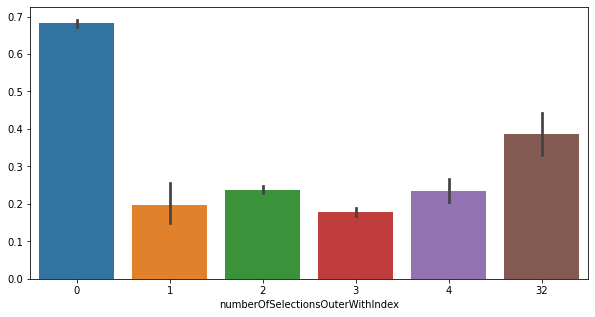

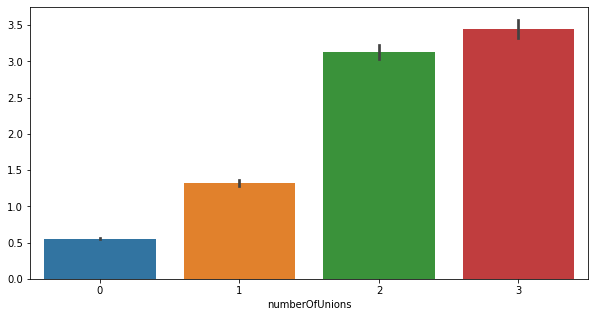

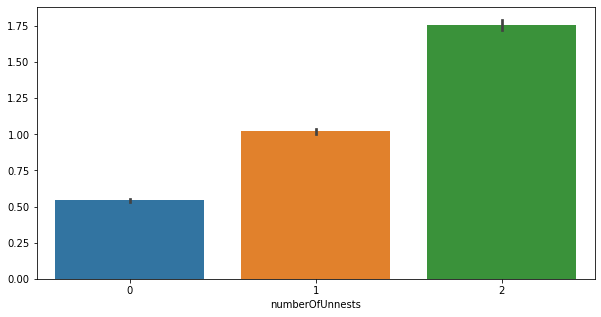

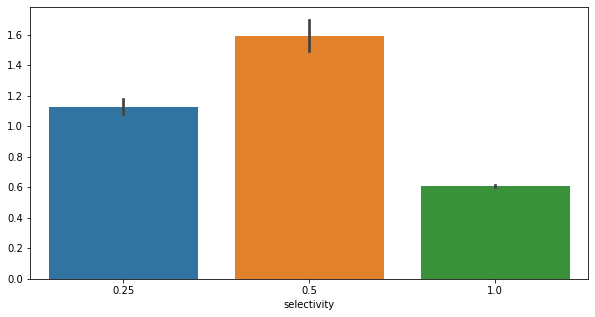

In [ ]:
#revisualize feature data
for var in x_columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x = var, y = Y , data = data[x_columns])

In [ ]:
#use pearson correlation 
#Correlation with output variable
cor_target = abs(C_mat["time"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5].sort_values(ascending=False)[1:]
relevant_features

numberOfJoins           0.717
numberOfRecords         0.628
alignmentOrJoin_J       0.622
numberOfAggregations    0.559
aggregations            0.540
Name: time, dtype: float64

Analyzing the correlation matrix with pearson we discover that the most important features in determining the execution time are

1. number of joins
2. number of records
3. the presence/absence of a join operation on the middleware



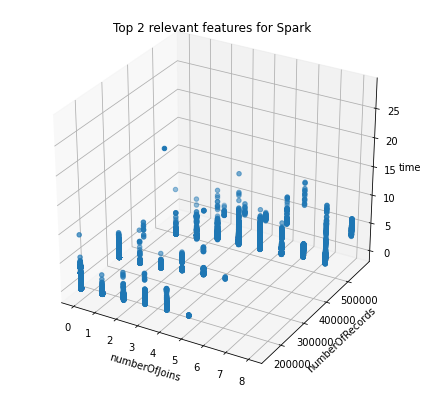

In [ ]:
#show 3d visualization of the data
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
x_index1 = x_columns.index(relevant_features.index[0])
x_index2 = x_columns.index(relevant_features.index[1])
fig = plt.figure(figsize=(25, 7))
ax1 = fig.add_subplot(131, projection='3d')
ax1.axes.set_xlabel(relevant_features.index[0])
ax1.axes.set_ylabel(relevant_features.index[1])
ax1.axes.set_zlabel("time")
ax1.scatter3D(X[:, x_index1], X[:, x_index2], Y)
ax1.set_title("Top 2 relevant features for " + db)
plt.show()


Despite the display of the two most important features over time, there are no large patterns and it is difficult to visualize data with more than 3 dimensions. But the correlation matrix reveals that the selected features still contribute to the result. The problem in addition to dimensionality is that the training data suffers from fluctuations over time which are part of the error.

In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardize data (0 mean, 1 stdev)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Models evaluation

In [ ]:
#import of models from both sklearn and keras
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, concatenate, Input
from sklearn.metrics import r2_score
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

## Classical models

In [ ]:
#define the train and tests
test_size = .33
seed = 7    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed) 

models =  [LinearRegression(), LinearRegression(fit_intercept=False), DecisionTreeRegressor(max_depth=2 if db != 'Spark' else 5), SVR(), 
              linear_model.Lasso(), linear_model.Lasso(alpha=0.1), linear_model.Lasso(alpha=0.1, fit_intercept=False), 
              linear_model.Ridge(),
              linear_model.Ridge(max_iter = 100, tol = 1E-8),
              linear_model.RidgeCV(), #use leave one out
              linear_model.RidgeCV(cv = 5), #use leave one out
              RandomForestRegressor(max_depth=2 if db != 'Spark' else 5), linear_model.SGDRegressor()]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE: 0.28
MSE: 0.34
R2: 0.71


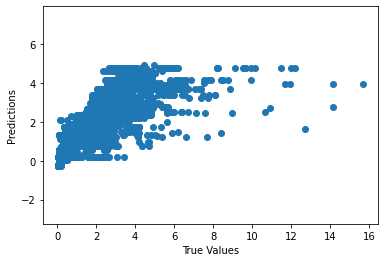

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
MAE: 0.71
MSE: 0.78
R2: 0.33


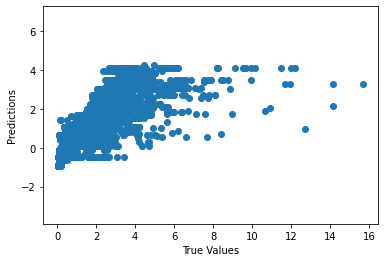

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
MAE: 0.26
MSE: 0.32
R2: 0.72


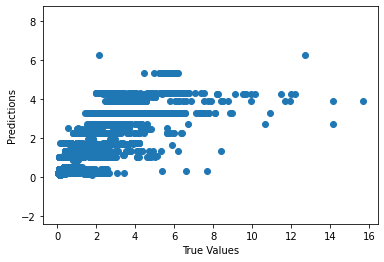

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MAE: 0.22
MSE: 0.35
R2: 0.70


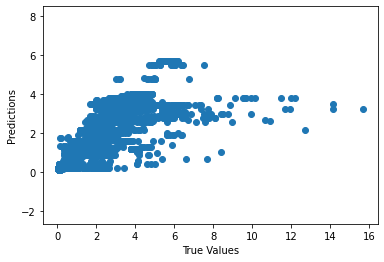

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MAE: 0.69
MSE: 1.17
R2: -0.00


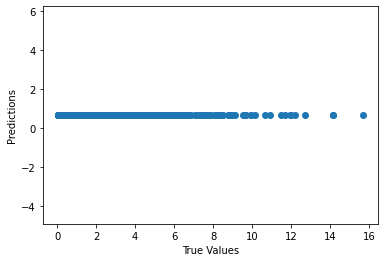

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MAE: 0.30
MSE: 0.38
R2: 0.67


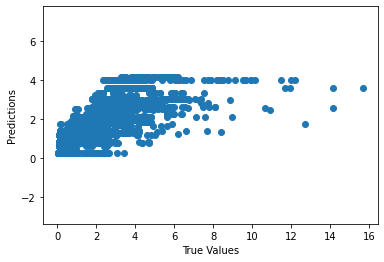

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MAE: 0.68
MSE: 0.82
R2: 0.29


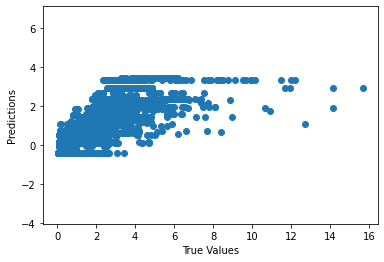

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MAE: 0.28
MSE: 0.34
R2: 0.71


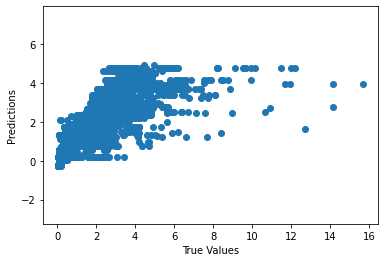

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
      random_state=None, solver='auto', tol=1e-08)
MAE: 0.28
MSE: 0.34
R2: 0.71


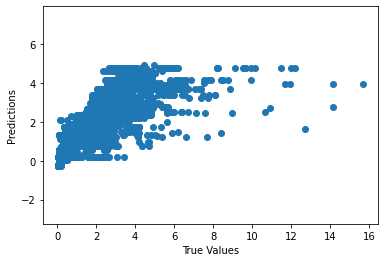

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
MAE: 0.28
MSE: 0.34
R2: 0.71


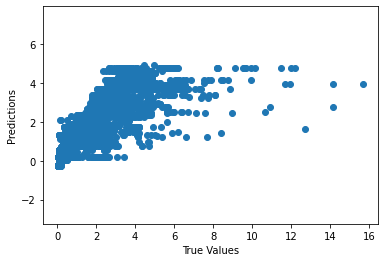

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
MAE: 0.28
MSE: 0.34
R2: 0.71


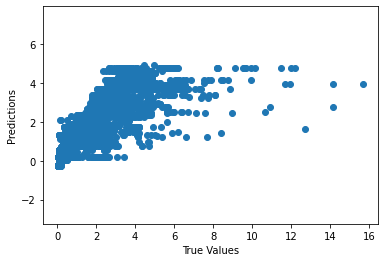

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
MAE: 0.26
MSE: 0.31
R2: 0.73


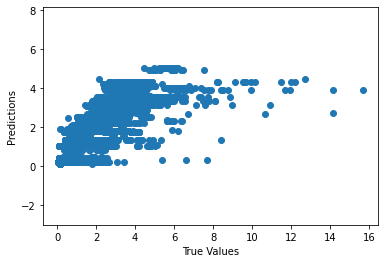

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
MAE: 0.28
MSE: 0.34
R2: 0.71


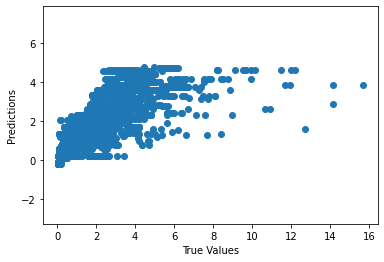

In [ ]:
#iterate over the selected models
for model in models:
  print(model)
  model.fit(X_train, Y_train)             

  # Make predictions using the testing set
  Y_Pred = model.predict(X_test)

  # The coefficients
  #print('Coefficients: ' % model.coef_)

  # Print some metrics
  print('MAE: %.2f' % mean_absolute_error(Y_test, Y_Pred))
  print('MSE: %.2f' % mean_squared_error(Y_test, Y_Pred))
  # The coefficient of determination: 1 is perfect prediction
  print('R2: %.2f' % r2_score(Y_test, Y_Pred))
  plot_prediction(Y_test, Y_Pred)

  if str(model).startswith("DecisionTreeRegressor") :
    #esport the decision tree
    estimator = model

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = x_columns,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    Image(filename = 'tree.png')

  # Plot 3d outputs is very confusing and not so meaningfull in this case
  # x_index1 = x_columns.index(relevant_features.index[0])
  # x_index2 = x_columns.index(relevant_features.index[1])
  # fig = plt.figure(figsize=(12, 4))
  # ax1 = fig.add_subplot(131, projection='3d')
  # ax1.plot(X_test[:, x_index1], X_test[:, x_index2], Y_test, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
  # ax1.scatter(X_test[:, x_index1], X_test[:, x_index2], Y_Pred, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
  # ax1.axes.set_xlabel(relevant_features.index[0])
  # ax1.axes.set_ylabel(relevant_features.index[1])
  # ax1.axes.set_zlabel("time")
  # plt.xticks(())
  # plt.yticks(())

  # plt.show()


From the evaluation we see that:
1. In case of LinearRegression in this problem is too important to set the intercept
2. Best models have an MSE of approximately 0.3 and an R2 of approximatilly 0.70
  - Most of the models obtains these result except when we set "**fit_intercept=False**" and use *Lasso*. This probably happens because Lasso encourages shrinking of coefficients to 0, i.e. dropping those variates from your model. On contrast, other regularization techniques like a ridge tend to keep all variates.
  - **RandomForestRegressor** is the best model, but we know that it is very likely to overfit, so we try to use cross validation for evaluate the problem.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# unified scoring API always maximizes the score, so scores which need to be minimized are negated in order for 
# the unified scoring API to work correctly. The score that is returned is therefore negated 
# when it is a score that should be minimized and left positive if it is a score that should be maximized.
def kfold(models, X_train, Y_train, seed=7, scoring='neg_mean_squared_error', n_splits=5):
    results = []
    names = []
    for model in models:
        kfold = model_selection.KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(str(model))
        msg = "%s: %f (%f)" % (str(model), cv_results.mean(), cv_results.std())
        print(msg)
    return pd.Series(results, index = names)

results = kfold(models, X_train, Y_train, seed)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False): -0.363859 (0.033847)
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False): -0.808276 (0.042055)
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'): -0.341065 (0.029003)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False): -0.366388 (0.038787)
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False): -1.205

In [ ]:
#print the models ranking
print(results
      .map(lambda x: x.mean()*-1) #apply mean on cv_result
      .sort_values(ascending=True) #sort the result
)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n                      max_depth=5, max_features='auto', max_leaf_nodes=None,\n                      max_samples=None, min_impurity_decrease=0.0,\n                      min_impurity_split=None, min_samples_leaf=1,\n                      min_samples_split=2, min_weight_fraction_leaf=0.0,\n                      n_estimators=100, n_jobs=None, oob_score=False,\n                      random_state=None, verbose=0, warm_start=False)    0.331
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,\n                      max_features=None, max_leaf_nodes=None,\n                      min_impurity_decrease=0.0, min_impurity_split=None,\n                      min_samples_leaf=1, min_samples_split=2,\n                      min_weight_fraction_leaf=0.0, presort='deprecated',\n                      random_state=None, splitter='best')                                                                                         

With the cross validation we have a confirmation of the previous ranking. As we see for the most of the models the mse is above 0.3 seconds^2







## NN

In [ ]:
# model loss MSE across epochs
def plot_model_loss(history, loss = "mae"):#or loss
  plt.subplot(2,1,2)
  plt.plot(history.history[loss], label="training")
  plt.plot(history.history["val_"+loss], label="validation")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.title(loss+' trend: training vs validation set')
  plt.tight_layout()
  plt.grid(False)
  plt.show()

loss_function = "mse"
batch_size = 32
epochs = 100

def create_checkpoint(checkpoint_name):
  checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
  #add early stopping after 5 times
  earlystopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
  return [checkpoint, earlystopping]

def print_statistics(model, xtest, xtrain, ytrain, ytest): 
  ypred = model.predict(xtest)
  score = model.evaluate(xtrain, ytrain)
  print("Test loss (MSE - MAE)")
  print(score)

  print("MSE: %.4f" % mean_squared_error(ytest, ypred))
  plot_prediction(ytest, ypred)

  # x_ax = range(len(ypred))
  # plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
  # plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
  # plt.legend()
  # plt.show()


  

### CNN

In [ ]:
#cnn
x, y = X, Y
#reshape the data
x = x.reshape(x.shape[0], x.shape[1], 1)
print(x.shape)
#split tran and test
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=test_size) 

(58785, 10, 1)


#### CNN1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 9, 32)             96        
_________________________________________________________________
flatten_8 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                18496     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 18,657
Trainable params: 18,657
Non-trainable params: 0
_________________________________________________________________


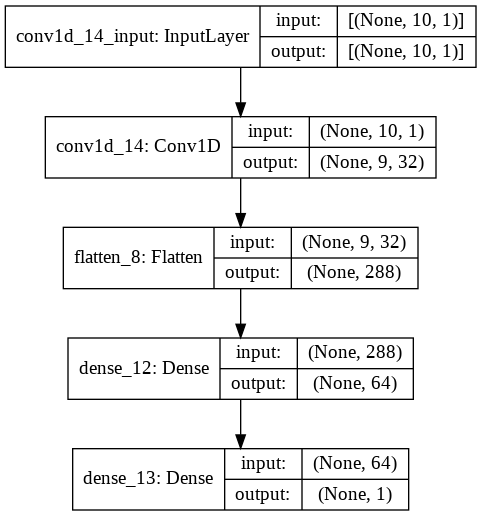

In [ ]:
#create the basic CNN
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(x.shape[1], 1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear")) # this activation is really important in case of regression
model.compile(loss=loss_function, optimizer="adam", metrics=['mae'])
 
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)


In [ ]:
#fit the model
wights_file = 'CNN.hdf5' # choose the best checkpoint 

history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=create_checkpoint(wights_file), 
                    validation_data=(xtest,ytest))


Epoch 00001: val_loss improved from inf to 0.34411, saving model to CNN.hdf5

Epoch 00002: val_loss did not improve from 0.34411

Epoch 00003: val_loss improved from 0.34411 to 0.32735, saving model to CNN.hdf5

Epoch 00004: val_loss improved from 0.32735 to 0.32499, saving model to CNN.hdf5

Epoch 00005: val_loss did not improve from 0.32499

Epoch 00006: val_loss did not improve from 0.32499

Epoch 00007: val_loss improved from 0.32499 to 0.32465, saving model to CNN.hdf5

Epoch 00008: val_loss did not improve from 0.32465

Epoch 00009: val_loss improved from 0.32465 to 0.32127, saving model to CNN.hdf5

Epoch 00010: val_loss did not improve from 0.32127

Epoch 00011: val_loss did not improve from 0.32127

Epoch 00012: val_loss did not improve from 0.32127

Epoch 00013: val_loss improved from 0.32127 to 0.31785, saving model to CNN.hdf5

Epoch 00014: val_loss did not improve from 0.31785

Epoch 00015: val_loss did not improve from 0.31785

Epoch 00016: val_loss did not improve from 

1231/1231 [==============================] - 2s 1ms/step - loss: 0.3130 - mae: 0.2471
Test loss (MSE - MAE)
[0.3129934072494507, 0.24706563353538513]
MSE: 0.3094


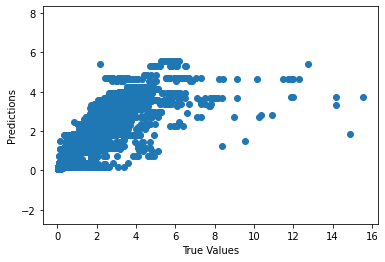

In [ ]:
wights_file = 'CNN.hdf5' # choose the best checkpoint 
model.load_weights(wights_file) # load weights for not retrain the model
print_statistics(model, xtest, xtrain, ytrain, ytest)

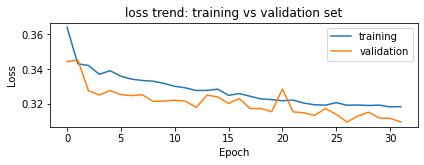

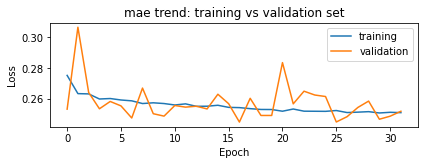

In [ ]:
plot_model_loss(history, "loss")
plot_model_loss(history, "mae")

This model seems not to overfit so much the data. Infact in the loss function when the training mse decrease also the validation do it.

The visualization of the MAE not give us a "linear view" of the problem, because MSE punish larger errors more than smaller errors, inflating or magnifying the mean error score. The MAE instead does not give more or less weight to different types of errors and instead the scores increase linearly with increases in error.
In our case we are more interested in the larger errors, as small errors could be natural fluctuations of the data.

#### CNN 2

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 5, 64)             448       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 3, 32)             6176      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2, 16)             1040      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

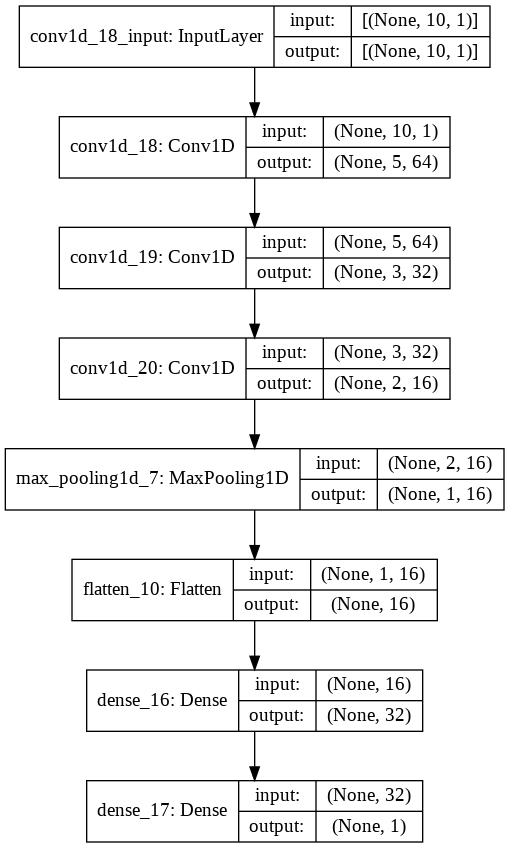

In [ ]:
#create deep CNN
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=6, activation="relu", input_shape=(x.shape[1], 1)))
model2.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model2.add(Conv1D(filters=16, kernel_size=2, activation="relu"))
model2.add(MaxPool1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(32, activation="relu"))
model2.add(Dense(1, activation="linear")) # this activation is really important in case of regression

model2.compile(loss=loss_function, optimizer="adam", metrics=["mae"])
 
model2.summary()
plot_model(model2,show_shapes=True, show_layer_names=True)

In [ ]:
#fit the model
wights_file = 'CNN2.hdf5' # choose the best checkpoint 

history2 = model2.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=create_checkpoint(wights_file), 
                    validation_data=(xtest,ytest))


Epoch 00001: val_loss improved from inf to 0.34010, saving model to CNN2.hdf5

Epoch 00002: val_loss did not improve from 0.34010

Epoch 00003: val_loss improved from 0.34010 to 0.32730, saving model to CNN2.hdf5

Epoch 00004: val_loss did not improve from 0.32730

Epoch 00005: val_loss did not improve from 0.32730

Epoch 00006: val_loss improved from 0.32730 to 0.32470, saving model to CNN2.hdf5

Epoch 00007: val_loss did not improve from 0.32470

Epoch 00008: val_loss did not improve from 0.32470

Epoch 00009: val_loss improved from 0.32470 to 0.32087, saving model to CNN2.hdf5

Epoch 00010: val_loss did not improve from 0.32087

Epoch 00011: val_loss did not improve from 0.32087

Epoch 00012: val_loss did not improve from 0.32087

Epoch 00013: val_loss did not improve from 0.32087

Epoch 00014: val_loss improved from 0.32087 to 0.31987, saving model to CNN2.hdf5

Epoch 00015: val_loss improved from 0.31987 to 0.31808, saving model to CNN2.hdf5

Epoch 00016: val_loss improved from 0

1231/1231 [==============================] - 2s 1ms/step - loss: 0.3126 - mae: 0.2470
Test loss (MSE - MAE)
[0.3126029372215271, 0.24698469042778015]
MSE: 0.3086


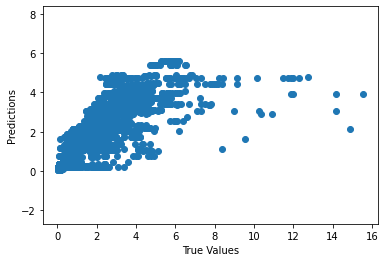

In [ ]:
wights_file = 'CNN2.hdf5' # choose the best checkpoint 
model2.load_weights(wights_file) # load weights for not retrain the model
print_statistics(model2, xtest, xtrain, ytrain, ytest)

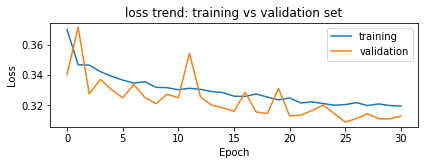

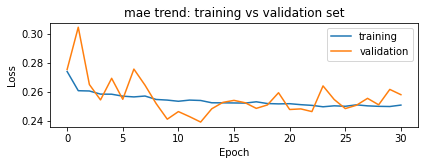

In [ ]:
plot_model_loss(history2, "loss")
plot_model_loss(history2, "mae")

The behaviour of this second NN is affected by some overfitting.
Let's try to add some dropout levels to this second NN.

#### CNN3

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 5, 64)             448       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 3, 32)             6176      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 16)             1040      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 16)               

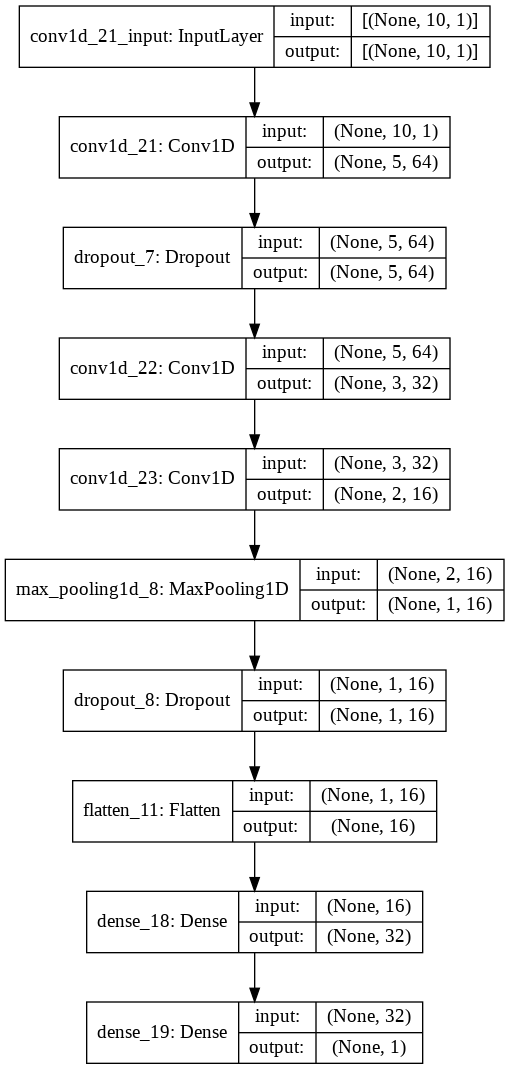

In [ ]:
#create deep CNN with drop out
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=6, activation="relu", input_shape=(x.shape[1], 1)))
model3.add(Dropout(0.5))
model3.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model3.add(Conv1D(filters=16, kernel_size=2, activation="relu"))
model3.add(MaxPool1D(pool_size=2))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(32, activation="relu"))
model3.add(Dense(1, activation="linear")) # this activation is really important in case of regression

model3.compile(loss=loss_function, optimizer="adam", metrics=['mae'])
 
model3.summary()
plot_model(model3,show_shapes=True, show_layer_names=True)

In [ ]:
#fit the model
weights_file = 'CNN3.hdf5' # choose the best checkpoint 

history3 = model3.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=create_checkpoint(weights_file), 
                    validation_data=(xtest,ytest))


Epoch 00001: val_loss improved from inf to 0.44944, saving model to CNN3.hdf5

Epoch 00002: val_loss improved from 0.44944 to 0.42331, saving model to CNN3.hdf5

Epoch 00003: val_loss did not improve from 0.42331

Epoch 00004: val_loss improved from 0.42331 to 0.39959, saving model to CNN3.hdf5

Epoch 00005: val_loss did not improve from 0.39959

Epoch 00006: val_loss did not improve from 0.39959

Epoch 00007: val_loss improved from 0.39959 to 0.39581, saving model to CNN3.hdf5

Epoch 00008: val_loss did not improve from 0.39581

Epoch 00009: val_loss did not improve from 0.39581

Epoch 00010: val_loss did not improve from 0.39581

Epoch 00011: val_loss did not improve from 0.39581

Epoch 00012: val_loss improved from 0.39581 to 0.35637, saving model to CNN3.hdf5

Epoch 00013: val_loss did not improve from 0.35637

Epoch 00014: val_loss improved from 0.35637 to 0.33885, saving model to CNN3.hdf5

Epoch 00015: val_loss did not improve from 0.33885

Epoch 00016: val_loss did not improve

1231/1231 [==============================] - 2s 1ms/step - loss: 0.3445 - mae: 0.2506
Test loss (MSE - MAE)
[0.3444598913192749, 0.25058090686798096]
MSE: 0.3389


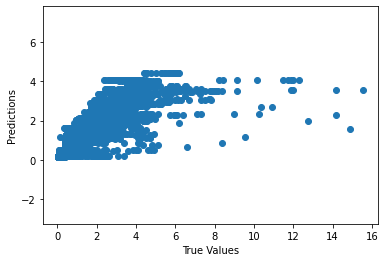

In [ ]:
weights_file = 'CNN3.hdf5' # choose the best checkpoint 

model3.load_weights(weights_file) # load weights for not retrain the model
print_statistics(model3, xtest, xtrain, ytrain, ytest)

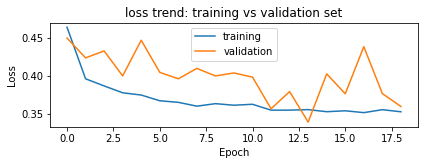

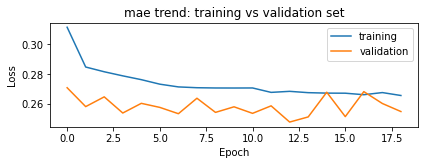

In [ ]:
plot_model_loss(history3, "loss")
plot_model_loss(history3, "mae")

Even in this case, with dropout, there seem there is some overfitting. 

#### Multi CNN


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 8, 32)        128         input_10[0][0]                   
____________________________________________________________________________________________

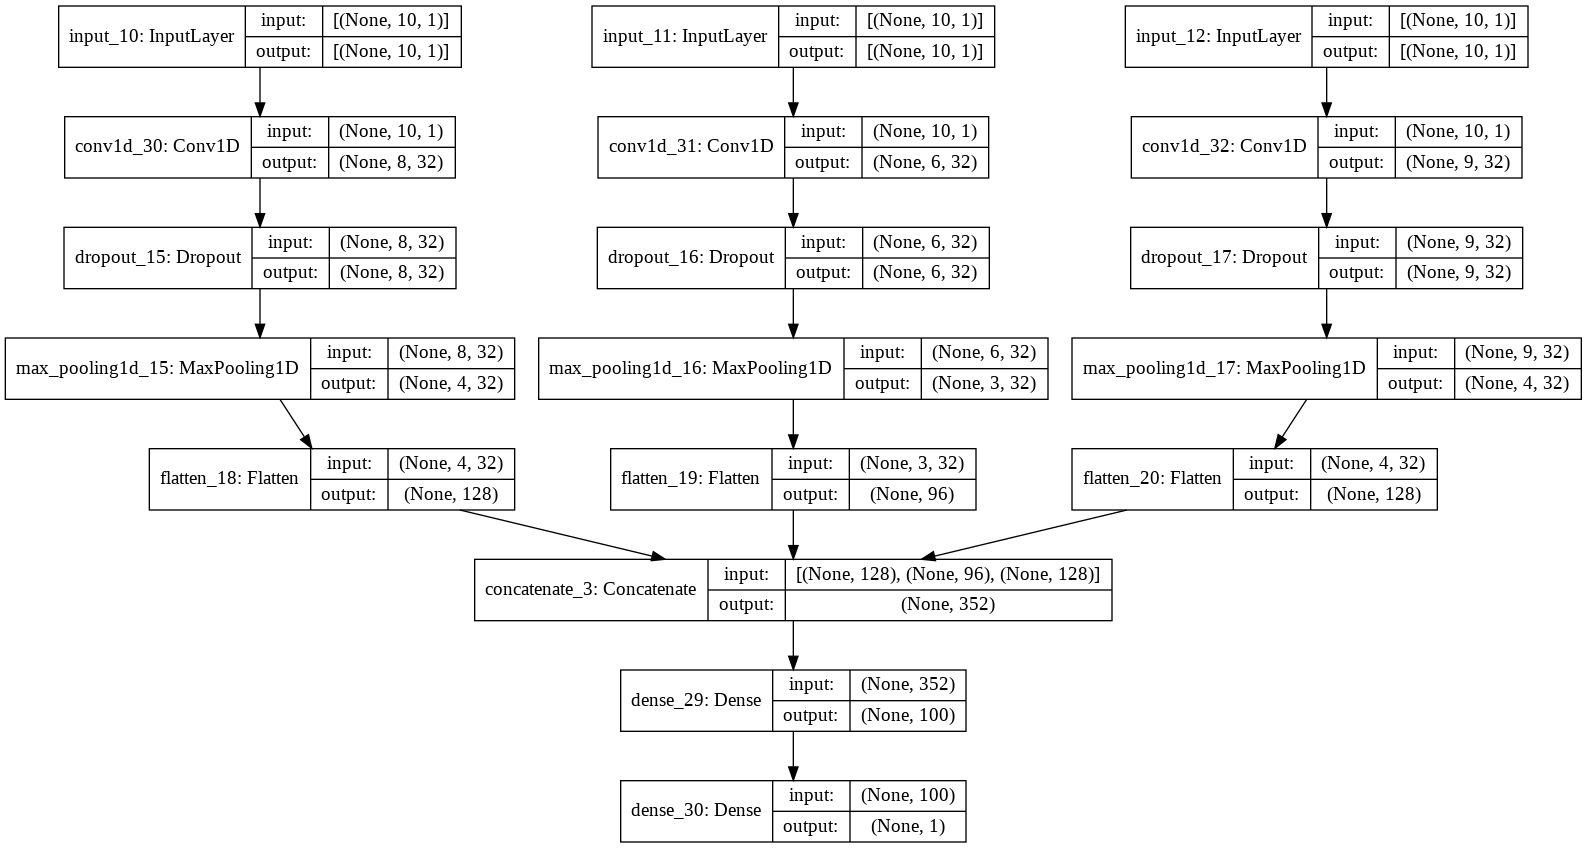

In [ ]:
#create deep CNN with drop out and change the starting filters numb

def get_model(kernel_size):
  input = Input(shape=(x.shape[1], 1))
  conv = Conv1D(filters=32, kernel_size=kernel_size, activation="relu")(input)
  drop = Dropout(0.5)(conv)
  pool = MaxPool1D(pool_size=2)(drop)
  flat = Flatten()(pool)
  return input, flat

# generate 3 model with different kernel_size
i1, f1 = get_model(3)
i2, f2 = get_model(5)
i3, f3 = get_model(2)
merged = concatenate([f1, f2, f3])

# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(1, activation='linear')(dense1)
model = Model(inputs=[i1, i2, i3], outputs=outputs)
# save a plot of the model
model.compile(loss=loss_function, optimizer="adam", metrics=['mae'])

model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
#fit the model
weights_file = 'multiCNN.hdf5' # choose the best checkpoint 
multi_cnn_history = model.fit([xtrain,xtrain,xtrain], ytrain, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=create_checkpoint(weights_file), 
                    validation_data=([xtest,xtest,xtest],ytest))


Epoch 00001: val_loss improved from inf to 0.33959, saving model to multiCNN.hdf5

Epoch 00002: val_loss did not improve from 0.33959

Epoch 00003: val_loss did not improve from 0.33959

Epoch 00004: val_loss improved from 0.33959 to 0.33856, saving model to multiCNN.hdf5

Epoch 00005: val_loss did not improve from 0.33856

Epoch 00006: val_loss did not improve from 0.33856

Epoch 00007: val_loss did not improve from 0.33856

Epoch 00008: val_loss did not improve from 0.33856

Epoch 00009: val_loss improved from 0.33856 to 0.32605, saving model to multiCNN.hdf5

Epoch 00010: val_loss did not improve from 0.32605

Epoch 00011: val_loss did not improve from 0.32605

Epoch 00012: val_loss did not improve from 0.32605

Epoch 00013: val_loss did not improve from 0.32605

Epoch 00014: val_loss did not improve from 0.32605


1231/1231 [==============================] - 2s 2ms/step - loss: 0.3325 - mae: 0.2648
Test loss (MSE - MAE)
[0.3325372636318207, 0.26478511095046997]
MSE: 0.3261


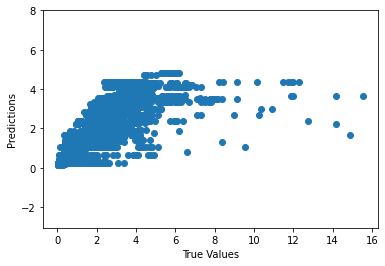

In [ ]:
weights_file = 'multiCNN.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load weights for not retrain the model
print_statistics(model, [xtest, xtest, xtest], [xtrain, xtrain, xtrain], ytrain, ytest)

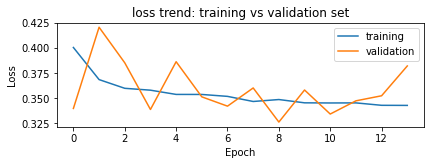

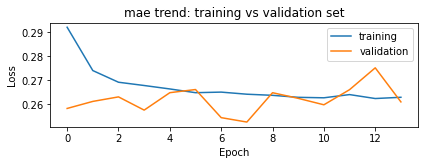

In [ ]:
plot_model_loss(multi_cnn_history, "loss")
plot_model_loss(multi_cnn_history, "mae")

Here is a three-headed model with three different kernel sizes allowing the model to read and interpret the sequence data at three different resolutions. The interpretations from all three heads are then concatenated within the model and interpreted by a fully-connected layer before a prediction is made. 
But this model seems overfit on the training loss and fails to generalize on the validation.

### MLP

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 166,273
Trainable params: 166,273
Non-trainable params: 0
_________________________________________________________________


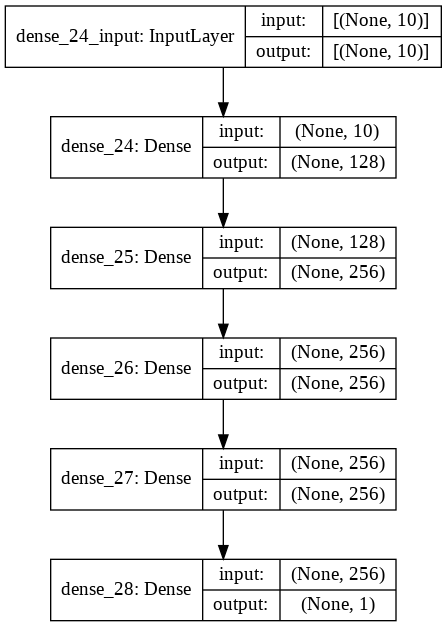

In [ ]:
#use the previous X/Y_train_test
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal', activation='relu', input_dim = X_train.shape[1]))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=loss_function, optimizer='adam', metrics=['mae'])
NN_model.summary()
#plot the model
plot_model(NN_model,show_shapes=True, show_layer_names=True)

In [ ]:
weights_file = 'NN.hdf5' # choose the best checkpoint 
NN_history = NN_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test,Y_test), 
                          callbacks=create_checkpoint(weights_file)) 


Epoch 00001: val_loss improved from inf to 0.32763, saving model to NN.hdf5

Epoch 00002: val_loss did not improve from 0.32763

Epoch 00003: val_loss did not improve from 0.32763

Epoch 00004: val_loss improved from 0.32763 to 0.32426, saving model to NN.hdf5

Epoch 00005: val_loss did not improve from 0.32426

Epoch 00006: val_loss improved from 0.32426 to 0.32262, saving model to NN.hdf5

Epoch 00007: val_loss improved from 0.32262 to 0.31527, saving model to NN.hdf5

Epoch 00008: val_loss improved from 0.31527 to 0.30950, saving model to NN.hdf5

Epoch 00009: val_loss did not improve from 0.30950

Epoch 00010: val_loss improved from 0.30950 to 0.30864, saving model to NN.hdf5

Epoch 00011: val_loss did not improve from 0.30864

Epoch 00012: val_loss did not improve from 0.30864

Epoch 00013: val_loss did not improve from 0.30864

Epoch 00014: val_loss did not improve from 0.30864

Epoch 00015: val_loss improved from 0.30864 to 0.30714, saving model to NN.hdf5

Epoch 00016: val_los

1231/1231 [==============================] - 2s 1ms/step - loss: 0.3182 - mae: 0.2471
Test loss (MSE - MAE)
[0.3181595206260681, 0.24714846909046173]
MSE: 0.3028


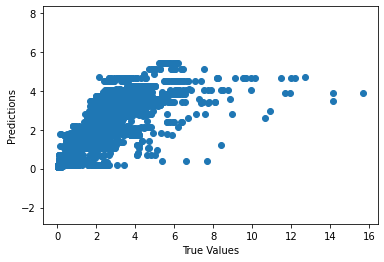

In [ ]:
weights_file = 'NN.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file) # load weights for not retrain the model
print_statistics(NN_model, X_test, X_train, Y_train, Y_test)

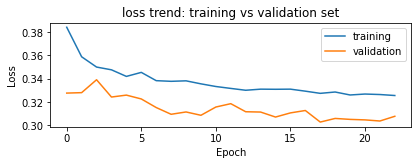

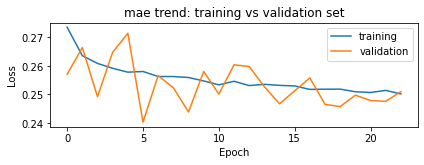

In [ ]:
plot_model_loss(NN_history, "loss")
plot_model_loss(NN_history, "mae")

The MLP performs good, in fact the loss drops both for the training and for the validation set.




# Conclusion

To conclude we see that with the right data preprocessing regression models seems not to be affected by overfitting considering the cross validation. 
As for the NNs, it is important to visualize the results and think about them. 
Through another tuning step maybe with some the CNN showed I could get more powerful result.
Within the MLP I actually get the best result in generalization with NNs.

The MLP error is less than the "classical" models results.
But in any case we talk of small improvements in the MSE.
So, remember that our goal was not to obtain a super precise model, as there are some unpredictable variability in the data that are not captured by the features and cannot be addressed.

After some tries I got that consider the MAE in this case in not so good, the MSE is a better measure of ther error.
The MSE punish larger errors more than smaller errors, inflating or magnifying the mean error score. The MAE instead does not give more or less weight to different types of errors and instead the scores increase linearly with increases in error.
In our case we are more interested in the larger errors, as small errors could be natural fluctuations of the data.